In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy
from scipy.sparse import random

m = 100  # Number of rows
n = 100  # Number of columns

# Generate a random sparse matrix
density = 0.3  # Density of non-zero elements
sparse_matrix = random(m, n, density=density, format='csr')

print(sparse_matrix)


  (0, 2)	0.8211170555612523
  (0, 4)	0.6201030561242417
  (0, 7)	0.4508187762673548
  (0, 8)	0.3334960095367562
  (0, 10)	0.6815900014907319
  (0, 15)	0.8636517706162854
  (0, 17)	0.0075562601480820835
  (0, 21)	0.8509684120544593
  (0, 23)	0.3669747521900678
  (0, 30)	0.9159234705232763
  (0, 33)	0.2775573491167861
  (0, 43)	0.6494402835714504
  (0, 45)	0.22773179057158555
  (0, 47)	0.725721114985638
  (0, 48)	0.2982376478507962
  (0, 52)	0.20605351226676094
  (0, 57)	0.9730512297935673
  (0, 58)	0.12853554857094485
  (0, 62)	0.5701508537668696
  (0, 64)	0.20211129693213803
  (0, 66)	0.40580973545118215
  (0, 70)	0.02969983879685345
  (0, 74)	0.7750156910617766
  (0, 75)	0.46087887296306784
  (0, 76)	0.40057558488710165
  :	:
  (99, 27)	0.40346260565250347
  (99, 28)	0.2942620931723532
  (99, 29)	0.07174325781524016
  (99, 31)	0.9769039970851934
  (99, 35)	0.365510792086307
  (99, 38)	0.020335346583734037
  (99, 39)	0.99395877569792
  (99, 43)	0.38647732613677577
  (99, 44)	0.86040625

In [4]:
import numpy as np

def matrix_factorization(A, d, num_iterations, learning_rate):
    m, n = A.shape
    U_history = []
    V_history = []
    loss_history = []


    # Initialize U and V with random values
    U = np.random.rand(m, d)
    V = np.random.rand(n, d)
    U_history.append(U.reshape((1,-1)))
    V_history.append(V.reshape((1,-1)))

    for iteration in range(num_iterations):
        # Compute the error matrix
        error = A - np.dot(U, V.T)
        # Compute the gradients for U and V
        grad_U = -2 * np.dot(error, V)
        grad_V = -2 * np.dot(error.T, U)

        # Update U and V using gradient descent
        U -= learning_rate * grad_U
        V -= learning_rate * grad_V
        
        loss_history.append(np.linalg.norm(error)/(m * n))
        U_history.append(U.reshape((1,-1)))
        V_history.append(V.reshape((1,-1)))
#         print('the error of iteration %d is %f' % (iteration, loss_history[-1]))

    return U, V, U_history, V_history, loss_history

In [5]:
A = scipy.sparse.csr_matrix(sparse_matrix)
d = 10
num_iterations = 100
learning_rate = 0.001

In [6]:
U, V, U_history, V_history, loss_history = matrix_factorization(A, d, num_iterations, learning_rate)

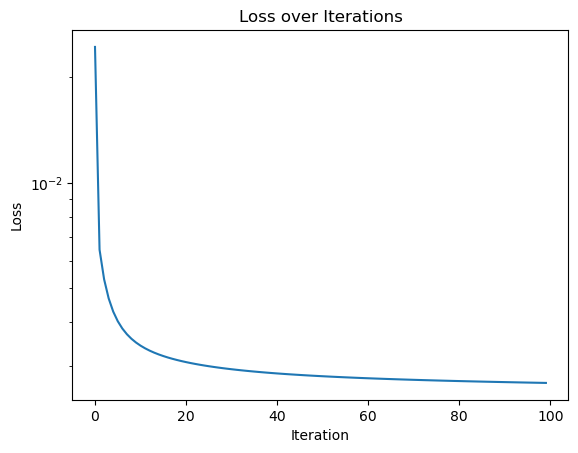

In [7]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss over Iterations')
plt.show()

In [8]:
U_history = np.array(U_history)
print(np.shape(U_history))
U_history_x = np.reshape(U_history[:-1], (num_iterations, -1))
U_history_y = np.reshape(U_history[1:], (num_iterations, -1))
V_history = np.array(V_history)
V_history_x = np.reshape(V_history[:-1], (num_iterations, -1))
V_history_y = np.reshape(V_history[1:], (num_iterations, -1))

(101, 1, 1000)


In [9]:
U_data_x, U_data_y, V_data_x, V_data_y = [U_history_x], [U_history_y], [V_history_x], [V_history_y]

In [10]:
training_num = 1000
for i in range(1, training_num):
    U, V, U_history, V_history, loss_history = matrix_factorization(A, d, num_iterations, learning_rate)
    U_history = np.array(U_history)
    U_history_x = np.reshape(U_history[:-1], (num_iterations, -1))
    U_history_y = np.reshape(U_history[1:], (num_iterations, -1))
    V_history = np.array(V_history)
    V_history_x = np.reshape(V_history[:-1], (num_iterations, -1))
    V_history_y = np.reshape(V_history[1:], (num_iterations, -1))
    U_data_x.append(U_history_x)
    U_data_y.append(U_history_y)
    V_data_x.append(V_history_x)
    V_data_y.append(V_history_y)

U_data_x = np.concatenate(U_data_x, axis=0)
U_data_y = np.concatenate(U_data_y, axis=0)
V_data_x = np.concatenate(V_data_x, axis=0)
V_data_y = np.concatenate(V_data_y, axis=0)

In [11]:
np.shape(V_data_x)

(100000, 1000)

In [12]:
para_data_x = np.concatenate((U_data_x, V_data_x), axis = 1)
para_data_y = np.concatenate((U_data_y, V_data_y), axis = 1)

In [13]:
# Build the model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import tensorflow as tf
from tensorflow import keras

class DicNN(Layer):
    """
    Trainable disctionries
    """
    
    def __init__(self, n_input, layer_sizes=[128,128,128], n_psi_train=64, **kwargs):
        """_summary_
        Args:
            layer_sizes (list, optional): Number of unit of hidden layer, activation = 'tanh'. Defaults to [64, 64].
            n_psi_train (int, optional): Number of unit of output layer. Defaults to 22.
        """
        super(DicNN, self).__init__(**kwargs)
        self.layer_sizes = layer_sizes
        self.input_layer = Dense(self.layer_sizes[0], name='Dic_input', use_bias=False)
        self.hidden_layers = [Dense(layer_sizes[i], activation='tanh', name='Dic_hidden_%d'%i) for i in range(len(layer_sizes))]        
        self.output_layer = Dense(n_psi_train, name='Dic_output')
        self.n_psi_train = n_psi_train
        self.inv_input_layer = Dense(self.layer_sizes[-1], name = 'Dic_input_inv', use_bias=False)
        self.inv_hidden_layers = [Dense(layer_sizes[-(i+1)], activation='tanh', name='Dic_hidden_%d_inv'%i) for i in range(len(layer_sizes))]
        self.inv_output_layer = Dense(n_input, name = 'Dic_output_inv')
        self.n_input = n_input
        
    def call(self, inputs):
        psi_x_train = self.input_layer(inputs)
        for layer in self.hidden_layers:
            psi_x_train = psi_x_train + layer(psi_x_train)
        outputs = self.output_layer(psi_x_train)
        return outputs
    
    def inv_call(self, inputs):
        x_inv = self.inv_input_layer(inputs)
        for layer in self.inv_hidden_layers:
            x_inv = x_inv + layer(x_inv)
        outputs = self.inv_output_layer(x_inv)
        return outputs
    
    def get_config(self):
        config = super(DicNN, self).get_config()
        config.update({
            'layer_sizes': self.layer_sizes,
            'n_psi_train': self.n_psi_train
        })
        return config

2023-06-12 20:26:23.565556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 20:26:23.655843: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 20:26:24.097641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-12 20:26:24.097688: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [14]:
dic = DicNN(n_input = np.shape(para_data_x)[1], n_psi_train = 106)
inputs_x = Input((np.shape(para_data_x)[1],))
model_psi = Model(inputs = inputs_x, outputs = dic.call(inputs_x), name = 'model_psi')

2023-06-12 20:26:24.824671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 20:26:26.656316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:18:00.0, compute capability: 8.6
2023-06-12 20:26:26.657730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22288 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:51:00.0, compute capability: 8.6
2023-06-12 20:26:26.658979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localho

In [15]:
inputs_x = Input((np.shape(para_data_x)[1],))
inputs_y = Input((np.shape(para_data_x)[1],))
psi_x = model_psi(inputs_x)
psi_y = model_psi(inputs_y)
k_layer = Dense(units = dic.n_psi_train, use_bias=False, name = 'k_layer')
outputs_x = k_layer(psi_x)
outputs = outputs_x - psi_y
model_koopman = Model(inputs = [inputs_x, inputs_y], outputs = outputs, name = 'model_koopman')

In [16]:
inputs_x = Input((np.shape(para_data_x)[1],))
psi_x = model_psi(inputs_x)
inputs_kpsi = Input((dic.n_psi_train,))
model_inv_psi = Model(inputs = inputs_kpsi, outputs = dic.inv_call(inputs_kpsi))
model_auto = Model(inputs = inputs_x, outputs = model_inv_psi(psi_x), name = 'model_auto')

In [17]:
input_x = tf.keras.layers.Input(shape=(para_data_x.shape[1],))
input_y = tf.keras.layers.Input(shape=(para_data_x.shape[1],))
output_auto = model_auto(input_x)
output_koopman = model_koopman([input_x, input_y])
combined_model = tf.keras.models.Model(inputs=[input_x, input_y], outputs=[output_auto, output_koopman], name = 'model_combined')

In [46]:
class para_loss(object):
    def __init__(self, lbd, shape):
        self.lbd = lbd
        self.shape = shape
    
    def loss_fun(self, y_pred, y_true):
        y_pred_auto = y_pred
        y_true_auto = y_true
        print(tf.shape(y_pred[0]))
        y_pred_auto_reshape = tf.reshape(y_pred_auto, self.shape)
        y_true_auto_reshape = tf.reshape(y_true_auto, self.shape)
        
        y_pred_auto_reshape_transposed = tf.transpose(y_pred_auto_reshape[1,:,:])
        y_true_auto_reshape_transposed = tf.transpose(y_true_auto_reshape[1,:,:])
        
        output_pred = tf.matmul(y_pred_auto_reshape[0,:,:], y_pred_auto_reshape_transposed)
        output_true = tf.matmul(y_true_auto_reshape[0,:,:], y_true_auto_reshape_transposed)
        
        output_pred = tf.reshape(output_pred, (1, -1))
        output_true = tf.reshape(output_true, (1, -1))
        
        return self.lbd * tf.keras.losses.MSE(y_pred[1], y_true[1]) + (1 - self.lbd) * tf.keras.losses.MSE(output_pred, output_true)


In [47]:
batch_size = 256
epochs = 1000
lbd = 0.1

In [48]:
loss = para_loss(lbd, (2,100,10))

In [49]:
combined_model.compile(optimizer='adam', loss=loss.loss_fun)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

para_data_x_train, para_data_x_test, para_data_y_train, para_data_y_test = train_test_split(para_data_x, para_data_y, test_size=0.2, random_state=42)

scaler = StandardScaler()

para_data_x_train_scaled = scaler.fit_transform(para_data_x_train)
para_data_y_train_scaled = scaler.fit_transform(para_data_y_train)

para_data_x_test_scaled = scaler.transform(para_data_x_test)
para_data_y_test_scaled = scaler.transform(para_data_y_test)

In [51]:
np.shape(para_data_x_train_scaled)

(80000, 2000)

In [52]:
# from tensorflow.keras.callbacks import TensorBoard

# log_dir = "logs/"

# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = combined_model.fit(
    [para_data_x_train_scaled, para_data_y_train_scaled],
    [para_data_x_train_scaled, tf.zeros_like(model_psi(para_data_x_train_scaled))],
    validation_data=(
        [para_data_x_test_scaled, para_data_y_test_scaled],
        [para_data_x_test_scaled, tf.zeros_like(model_psi(para_data_x_test_scaled))]
    ),
    verbose=1,
    epochs=epochs,
    batch_size=batch_size
#     callbacks=[tensorboard_callback]
)


Epoch 1/1000
Tensor("loss_fun/Shape:0", shape=(1,), dtype=int32)
Tensor("loss_fun_1/Shape:0", shape=(1,), dtype=int32)


ValueError: in user code:

    File "/home/shiqi/anaconda3/envs/tensor-koopman/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_3574362/2305107599.py", line 10, in loss_fun  *
        y_pred_auto_reshape = tf.reshape(y_pred_auto, self.shape)

    ValueError: Dimension size must be evenly divisible by 106 but is 2000 for '{{node loss_fun_1/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](IteratorGetNext:3, loss_fun_1/Reshape/shape)' with input shapes: [?,106], [3] and with input tensors computed as partial shapes: input[1] = [2,100,10].


In [ ]:
combined_model([para_data_x_train_scaled, para_data_y_train_scaled])